In [0]:
import torch
import torch.nn as nn
import numpy as np
import copy
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
from snip_prunner import Prunner

In [0]:
class LinearLayer(nn.Module):
    def __init__(self, input_dim, output_dim, act='relu', use_bn=False):
        super(LinearLayer, self).__init__()
        self.use_bn = use_bn
        self.lin = nn.Linear(input_dim, output_dim)
        self.act = nn.ReLU() if act == 'relu' else act
        if use_bn:
            self.bn = nn.BatchNorm1d(output_dim)
    def forward(self, x):
        if self.use_bn:
            return self.bn(self.act(self.lin(x)))
        return self.act(self.lin(x))

In [0]:
class Net(nn.Module):
    def __init__(self, in_dims, hid_dims, out_dims):
        super(Net, self).__init__()
        self.layers = nn.Sequential(LinearLayer(in_dims, hid_dims, use_bn=True),
                                   LinearLayer(hid_dims, hid_dims, use_bn=True),
                                   nn.Linear(hid_dims, out_dims))
    def forward(self, x):
        return self.layers(x.view(x.shape[0], -1))

In [0]:
torch.manual_seed(2019)
model = Net(784, 300, 10)
train_ds = MNIST('../data/', train=True, transform=transforms.ToTensor(), download=True)
val_ds = MNIST('../data/', train=False, transform=transforms.ToTensor(), download=True)
train_dl = DataLoader(train_ds, batch_size=100, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=100, shuffle=True)
criterion = nn.CrossEntropyLoss()
prunner = Prunner(model, criterion, train_dl)

In [0]:
model, masks = prunner.prun(compression_factor=0.98, num_batch_sampling=1)

In [36]:
for n, w in model.named_parameters():
    print(n, (w != 0).sum())

layers.0.lin.weight tensor(3840, device='cuda:0')
layers.0.lin.bias tensor(300, device='cuda:0')
layers.0.bn.weight tensor(300, device='cuda:0')
layers.0.bn.bias tensor(0, device='cuda:0')
layers.1.lin.weight tensor(1899, device='cuda:0')
layers.1.lin.bias tensor(300, device='cuda:0')
layers.1.bn.weight tensor(300, device='cuda:0')
layers.1.bn.bias tensor(0, device='cuda:0')
layers.2.weight tensor(824, device='cuda:0')
layers.2.bias tensor(10, device='cuda:0')


In [37]:
for mask in masks:
    print(mask.sum())

tensor(3840., device='cuda:0')
tensor(1899., device='cuda:0')
tensor(824., device='cuda:0')


In [0]:
from torched.trainer_utils import Train

In [0]:
trainer = Train(model, [train_dl, val_dl], cuda=True)

In [40]:
trainer.lr_find(crit=criterion, opt='adamW')

Train Loss 0.744214:  66%|██████▌   | 394/600 [00:06<00:03, 62.06it/s]


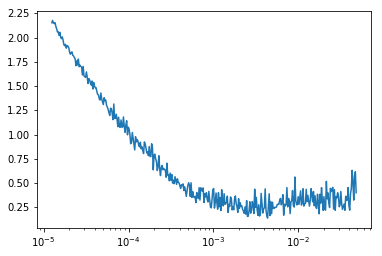

In [41]:
trainer.plot_lrs()

In [42]:
trainer.train(1e-4, 3, 2, criterion, opt='adamW')

Valid Loss 0.250065: 100%|██████████| 100/100 [00:01<00:00, 85.42it/s]


In [43]:
for n, w in trainer.model.named_parameters():
    print(n, (w != 0).sum())

layers.0.lin.weight tensor(3840, device='cuda:0')
layers.0.lin.bias tensor(300, device='cuda:0')
layers.0.bn.weight tensor(300, device='cuda:0')
layers.0.bn.bias tensor(216, device='cuda:0')
layers.1.lin.weight tensor(1899, device='cuda:0')
layers.1.lin.bias tensor(300, device='cuda:0')
layers.1.bn.weight tensor(300, device='cuda:0')
layers.1.bn.bias tensor(238, device='cuda:0')
layers.2.weight tensor(824, device='cuda:0')
layers.2.bias tensor(10, device='cuda:0')


In [0]:
def epoch(loader, model, opt=None):
    """Standard training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.cuda(), y.cuda()
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [0]:
err, loss = epoch(val_dl, trainer.model)

In [46]:
1 - err

0.9329

In [47]:
COMPRESSION_FACTORS = [0.1, 0.25, 0.50, 0.90, 0.98]
BATCH_SAMPLING = [1, 10]
ACCURACIES = []
PARAMETERS = []
for cf in COMPRESSION_FACTORS:
  for bs in BATCH_SAMPLING:
    net = Net(784, 300, 10)
    prunner = Prunner(net, criterion, train_dl)
    model, masks = prunner.prun(compression_factor=cf, num_batch_sampling=bs)
    trainer = Train(model, [train_dl, val_dl], cuda=True)
    trainer.train(1e-4, 3, 2, criterion, opt='adamW')
    err, _ = epoch(val_dl, trainer.model)
    ACCURACIES.append(1 - err)
    PARAMETERS.append(sum([(w != 0).sum() for _, w in trainer.model.named_parameters()]))

Valid Loss 0.076484: 100%|██████████| 100/100 [00:01<00:00, 84.88it/s]


Valid Loss 0.073268: 100%|██████████| 100/100 [00:01<00:00, 81.44it/s]


Valid Loss 0.072474: 100%|██████████| 100/100 [00:01<00:00, 86.85it/s]


Valid Loss 0.075099: 100%|██████████| 100/100 [00:01<00:00, 81.62it/s]


Valid Loss 0.077118: 100%|██████████| 100/100 [00:01<00:00, 84.25it/s]


Valid Loss 0.077972: 100%|██████████| 100/100 [00:01<00:00, 87.02it/s]


Valid Loss 0.116246: 100%|██████████| 100/100 [00:01<00:00, 85.11it/s]


Valid Loss 0.119134: 100%|██████████| 100/100 [00:01<00:00, 84.70it/s]


Valid Loss 0.260017: 100%|██████████| 100/100 [00:01<00:00, 81.85it/s]


Valid Loss 0.239391: 100%|██████████| 100/100 [00:01<00:00, 85.39it/s]


In [48]:
ACCURACIES

[0.9774, 0.977, 0.9779, 0.9779, 0.9774, 0.9767, 0.9669, 0.9669, 0.9301, 0.9369]

In [49]:
PARAMETERS

[tensor(230229, device='cuda:0'),
 tensor(264825, device='cuda:0'),
 tensor(228164, device='cuda:0'),
 tensor(247959, device='cuda:0'),
 tensor(165905, device='cuda:0'),
 tensor(165896, device='cuda:0'),
 tensor(34582, device='cuda:0'),
 tensor(34570, device='cuda:0'),
 tensor(8230, device='cuda:0'),
 tensor(8213, device='cuda:0')]